# Kolmogorov-Arnold Network-based Forecasting of Cutaneous Leishmaniasis in Antioquia, Colombia Using Relative Risk and Climate Signals

## Executive Summary


In this project, I generated short‑horizon monthly forecasts of the activity of cutaneous leishmaniasis (CL) in Antioquia, Colombia, using log relative risk (RR) as the primary signal and Kolmogorov–Arnold Networks (KANs) as the modeling framework. The target is $y=\log\!\big((casesobserved+1)/(casesexpected+1)\big)$, which centers the expected baseline at $y=0$ ($RR=e^y=1$) and expresses departures as multiplicative changes (e.g., $y=0.10\Rightarrow RR\approx1.105$, or $\sim10.5\%$ above expected). I built a supervised panel that combines autoregressive $y$ lags, climate/ENSO lags chosen by cross‑correlation, seasonality (month sine/cosine), ENSO regime indicators, and a static altitude control, then trained a KAN with Bayesian Optimization for hyperparameters. Chronological train/validation/test splits (2007–2018, 2019–2020, 2021) avoided temporal leakage; the final model achieved test MSE $\approx0.153$ on log(RR). Department‑level plots (calendar dates on the x‑axis) show actual and predicted trajectories, followed by an adaptive 12‑month forecast that indicates a transition from below‑expected to above‑expected activity under a baseline climate assumption. For clinical and public‑health users, RR provides an interpretable, comparable index: $RR>1$ flags months with higher‑than‑expected activity; $RR<1$ flags lower‑than‑expected activity.



## Introduction


Cutaneous leishmaniasis (CL) is a vector‑borne parasitic disease transmitted by phlebotomine sandflies, with heterogeneous burden across Colombia’s diverse eco‑epidemiological settings. Antioquia, a populous department with marked environmental gradients and occupational exposures, has reported substantial CL activity, making it an appropriate target for near‑term forecasting and operational surveillance. Effective clinical and public‑health decisions benefit from timely indicators that distinguish unusual risk from expected seasonal baselines and remain comparable across municipalities and months.


This repository assembles a monthly panel (2007–2021) and models one‑step‑ahead departures from expected activity using log(relative risk), $y=\log\!\big((casesobserved+1)/(casesexpected+1)\big)$. RR is favored over raw counts for three reasons: it normalizes for exposure/population differences, enabling fairer spatial and temporal comparisons; it stabilizes variance via log transformation (improving short‑horizon learning); and it yields a direct, practitioner‑friendly interpretation—$y>0$ ($RR>1$) indicates above‑expected activity (e.g., "~20% above usual"), $y<0$ ($RR<1$) indicates suppression, and $y\approx0$ ($RR\approx1$) indicates near baseline. The aim is to deliver an interpretable, reproducible tool that integrates recent history, climate/ENSO signals, and seasonality to anticipate short‑term departures from expected CL activity, supporting situational awareness, triage, and resource allocation in Antioquia.

## Dataset
This project used a monthly panel assembled for Colombia’s municipalities from 2007 through 2021. The dataset [[1](https://data.mendeley.com/datasets/cgxfzwrg7h/1)] provides disease burden variables—observed cases ($casesobserved$) and expected cases ($casesexpected$)—together with time stamps ($year$, $month$, and a monotonic month index $Period$), municipality identifiers ($CodeDANE$) and derived department codes, static geography (e.g., minimum elevation $minmasl$), and climate/ENSO covariates (e.g., $SST3$, $SST4$, $SST34$, $SST12$, $Esoi$, $soi$, $NATL$, $SATL$, $TROP$) plus a categorical ENSO regime indicator ($phenomenon2$). For the analyses in this project, I normalized municipality codes, zeroed in on cases from Antioquia Department, and restricted to municipalities with $minmasl < 1700$ to focus on a coherent eco‑epidemiological stratum. The resulting panel is ordered by municipality and month, and missing values in continuous series (target and climate indices) are imputed per municipality using linear interpolation with edge forward/backward fill. The forecasting target is defined as log relative risk, $y = \log\!\big((casesobserved + 1)/(casesexpected + 1)\big)$, which centers “expected” at zero and facilitates comparison across municipalities and seasons.


## Methodology

I modeled one‑step‑ahead log relative risk at the municipal level, predicting $y_{t+1}$ from features at month $t$. Feature design balances temporal signal, climate forcing, seasonality, and simple ecology:
- Autoregressive lags of $y$: $t-1$, $t-2$, $t-3$, $t-6$, $t-12$.
- Climate/ENSO lags: for each index ($SST3$, $SST4$, $SST34$, $SST12$, $Esoi$, $soi$, $NATL$, $SATL$, $TROP$), a cross‑correlation scan on the department‑aggregated series selects up to three lead times (1–9 months) with strongest association to $y$; these lags are encoded at $t$.
- Seasonality: month‑of‑year via $\sin(2\pi m/12)$ and $\cos(2\pi m/12)$.
- ENSO regime: one‑hot indicators for $phenomenon2$ (Neutral, La Niña, El Niño).
- Static covariate: $minmasl$ (altitude proxy).


Per municipality, I built $(X_t, y_{t+1})$ samples once lag history is sufficient, concatenate across municipalities, and retain metadata (IDs, $Period$) for consistent splitting and aggregation. To prevent temporal leakage, I used a blocked split by year: Train (2007–2018), Validation (2019–2020), and Test (2021). A StandardScaler was fitted on Train features only and applied to Validation/Test.



Modeling employed a KAN with $width=[input\_dim, hidden\_dim, 1]$; $grid$ and $k$ govern spline resolution and basis richness per edge. Training uses mini‑batches (default size 2048), Adam, mixed precision on GPU (if available), and early stopping on validation loss. Hyperparameters $(hidden\_dim, grid, k, lr, epochs)$ were tuned via Bayesian Optimization on the validation window using a compact, speed‑oriented domain; each trial trains a fresh KAN on Train and is scored by validation MSE. The final model (best hyperparameters) was retrained on Train+Validation with early stopping, then evaluated on Train, Validation, and held‑out Test. For visualization, municipal predictions/targets were aggregated to a department‑level mean aligned to target months ($target\_period=Period+1$), and an adaptive 12‑month forecast was generated by iteratively rolling forward: at each step, predicted $y$ was fed back as the next lag, and climate indices were held constant (baseline scenario).


## On Kolmogorov–Arnold Networks (KANs)


Kolmogorov–Arnold Networks (KANs) are inspired by the Kolmogorov–Arnold superposition theorem, which states that multivariate continuous functions can be represented by finite compositions and sums of univariate functions. Operationally, modern KANs implement learnable 1D functions (often parameterized by spline bases) on edges, combining them additively across a sparse network to approximate complex multivariate mappings with enhanced interpretability. In practice, each edge learns a smooth, low‑dimensional transformation from an input feature to the target, and the network sums these contributions to produce predictions. Hyperparameters such as $grid$ (spline resolution) and $k$ (basis multiplicity) control functional flexibility; $width=[input\_dim, hidden\_dim, 1]$ specifies layer sizes.


KANs offer two practical benefits here. First, they provide representational efficiency for tabular, structured signals (lags, seasonality, climate indices), capturing nonlinearities with compact, smooth functions. Second, they support interpretability: learned 1D edge functions can be visualized and inspected to understand how each feature contributes across its range—well aligned with RR’s goal of explaining departures from expected levels. I employed mini‑batch training with Adam, mixed precision when available, early stopping on validation loss, and Bayesian Optimization to select $hidden\_dim$, $grid$, $k$, learning rate, and epoch cap.


## On Relative Risk
 
I modeled the monthly burden of cutaneous leishmaniasis as log relative risk, defined as $y = \log\!\left(\frac{casesobserved + 1}{casesexpected + 1}\right)$. This target centers the expected baseline at $y=0$ (i.e., relative risk $RR = e^{y} = 1$) and expresses deviations as multiplicative departures from “usual” levels for a given place and time. Using relative risk rather than raw counts offers two advantages. First, it normalizes for exposure/population differences across municipalities and seasons, enabling fairer comparisons and reducing heterogeneity that can obscure temporal signal. Second, it stabilizes variance (via the $+1$ offset and the log transformation), improving statistical efficiency for short-horizon forecasting. Practically, interpretation is straightforward: $y>0$ ($RR>1$) indicates higher-than-expected activity, $y<0$ ($RR<1$) indicates lower-than-expected activity, and $y\approx0$ ($RR\approx1$) indicates near-expected levels. Converting to percent change is immediate: $\%\,\text{excess} = (e^{y}-1)\times 100\%$ (e.g., $y=0.10 \Rightarrow RR\approx1.105$ or about $10.5\%$ above expected).

In [2]:
%pip install git+https://github.com/KindXiaoming/pyKAN.git
%pip install bayesian-optimization
%pip install pyyaml

  Cloning https://github.com/KindXiaoming/pyKAN.git to /tmp/pip-req-build-y6ft4wj5
  Running command git clone --filter=blob:none --quiet https://github.com/KindXiaoming/pyKAN.git /tmp/pip-req-build-y6ft4wj5
  Resolved https://github.com/KindXiaoming/pyKAN.git to commit ecde4ec3274d3bef1ad737479cf126aed38ab530
  Preparing metadata (setup.py) ... done
  Created wheel for pykan: filename=pykan-0.2.8-py3-none-any.whl size=78310 sha256=d6c3cd0dd8a5a9455b99653922b89720ec36bf4c409cf454c747a05d6c352b73
  Stored in directory: /tmp/pip-ephem-wheel-cache-hw8qfdjd/wheels/d9/7c/c4/7e26b65f25c0b1e0acc6c88ec1fe4e345283e9b6d664623085
Successfully built pykan

[notice] A new release of pip is available: 25.2 -> 26.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 25.2 -> 26.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated pack

Checkpoint directory: /work/files/workspace/checkpoints/run_antioquia_20260228_134610
Loaded rows: 177480
Rows after altitude/geography filtering: 20340
Departments present: [5]
Municipalities: 113 | Years: 2007–2021
Selected climate lags: {'SST3': [5, 4, 6], 'SST4': [4, 2, 3], 'SST34': [3, 6, 9], 'SST12': [6, 1, 2], 'Esoi': [8, 5, 9], 'soi': [9, 8, 3], 'NATL': [1, 8, 9], 'SATL': [2, 1, 4], 'TROP': [2, 3, 6]}
Supervised samples: 18871 | Features: 38
Split sizes — Train: 14916, Val: 2712, Test: 1243
|   iter    |  target   | hidden... |   grid    |     k     |    lr     |  epochs   |
-------------------------------------------------------------------------------------
| 1         | -0.169609 | 32.988962 | 2.9507143 | 2.7319939 | 0.0013979 | 17.340279 |
| 2         | -0.168509 | 27.743868 | 2.0580836 | 2.8661761 | 0.0014016 | 25.621088 |
| 3         | -0.167593 | 28.401708 | 2.0140796 | 2.8995852 | 0.0017300 | 21.418117 |
| 4         | -0.167980 | 28.143635 | 2.5200844 | 2.2138115 | 0.00

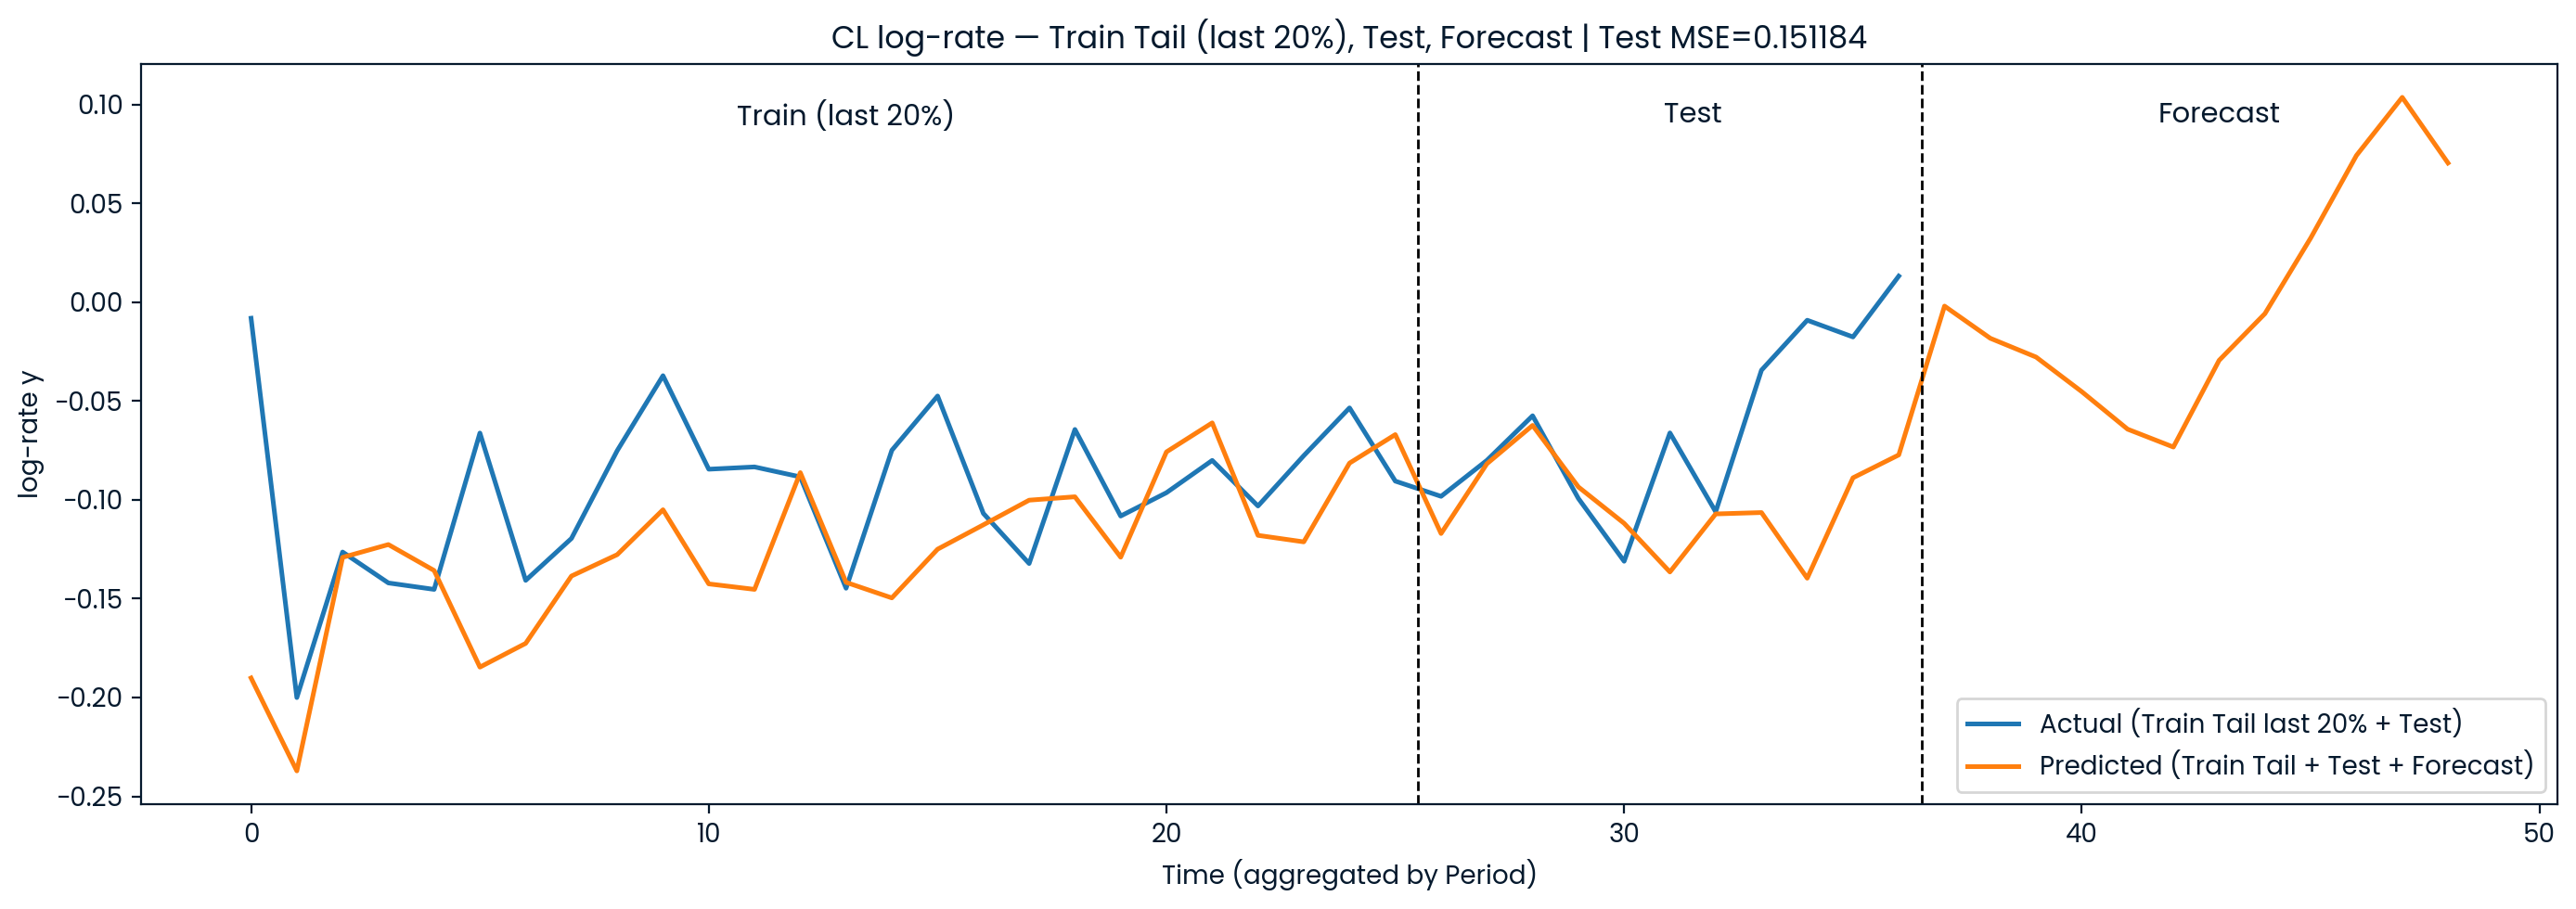

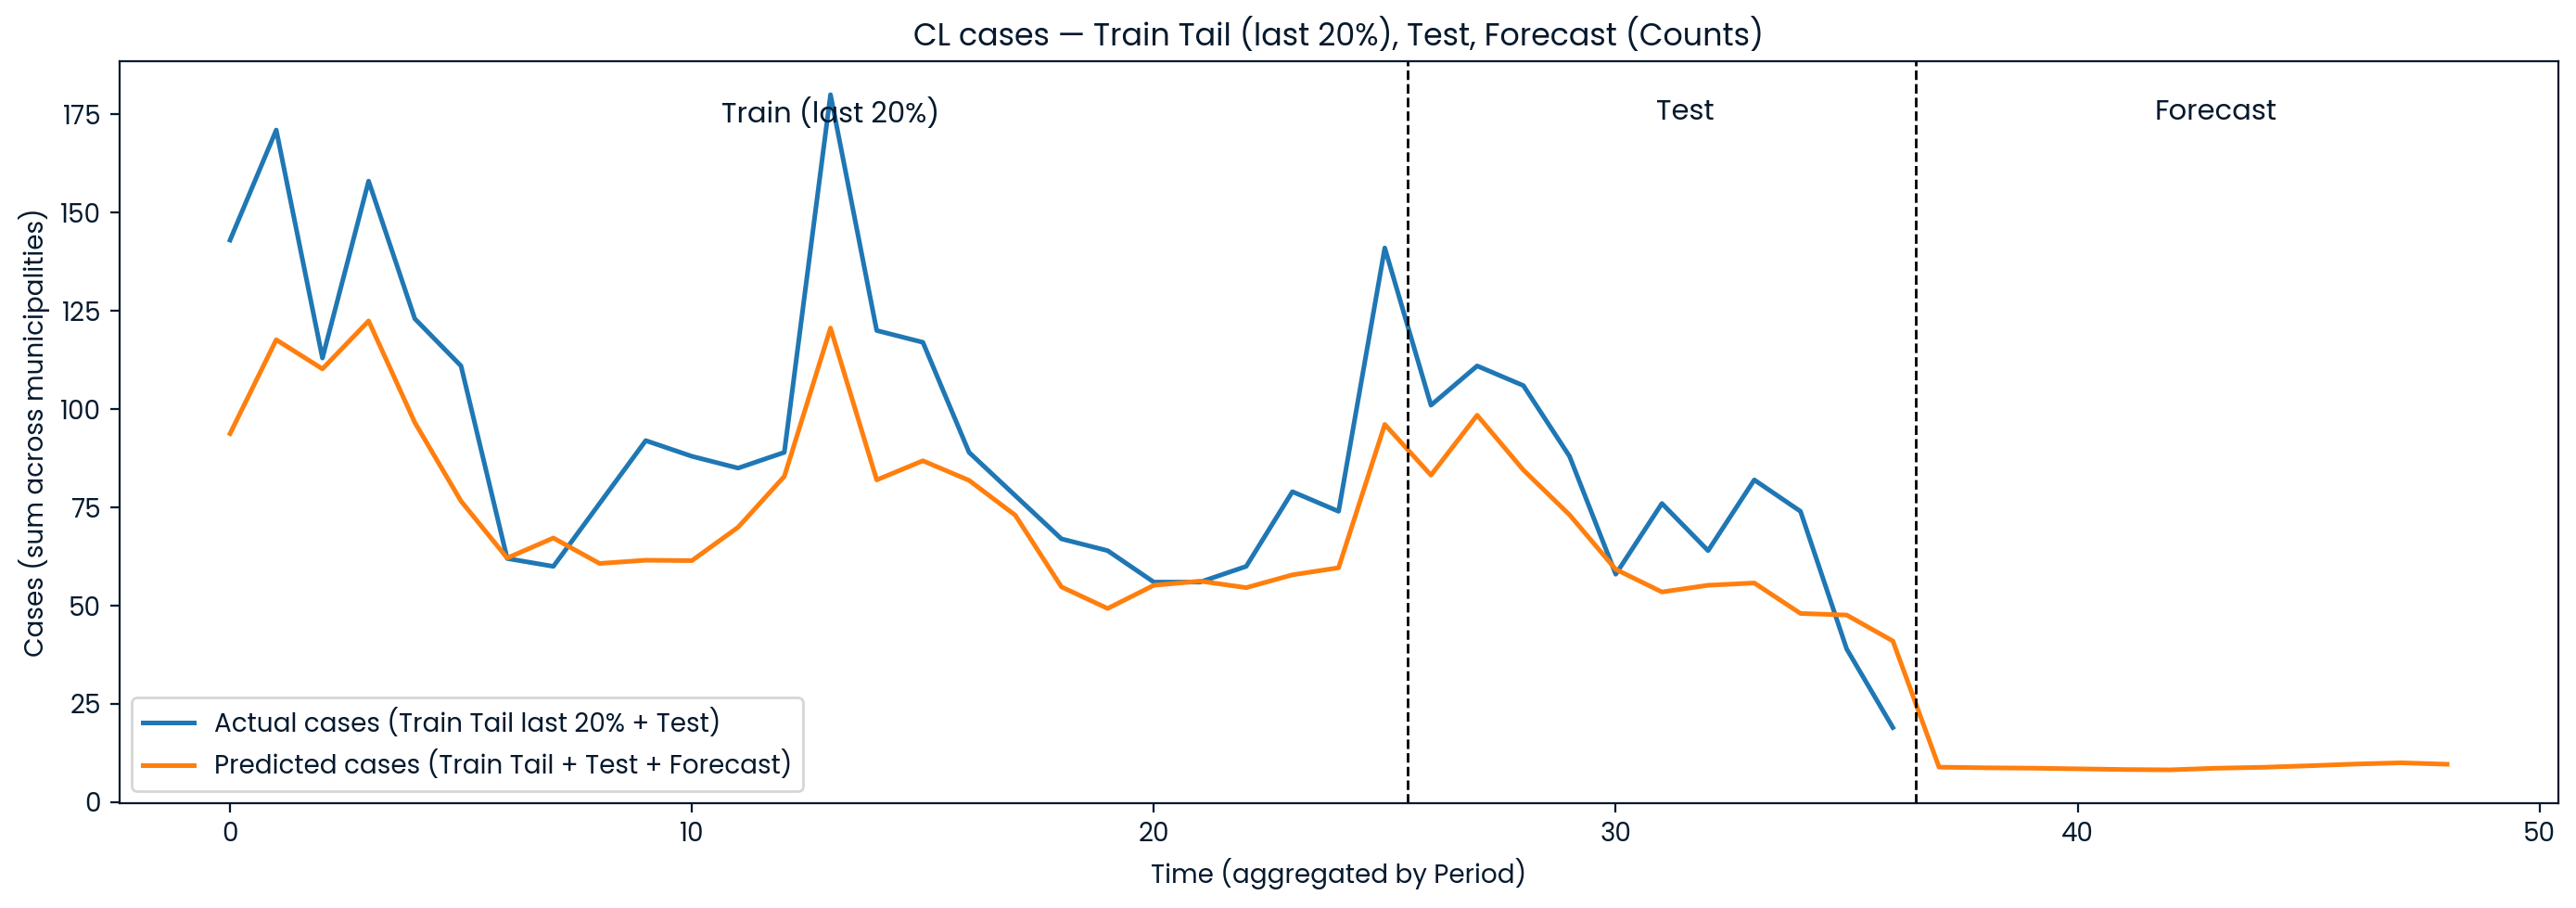

Artifacts saved to: /work/files/workspace/checkpoints/run_antioquia_20260228_134610
Done.


In [3]:
# ---------------------------------------------
# Requirements:
# pip install pandas numpy matplotlib scikit-learn kan bayesian-optimization pyyaml joblib
# Optional for speed: PyTorch 2.x for torch.compile
# ---------------------------------------------
import io
import os
import time
import json
import zipfile
from pathlib import Path
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

from sklearn.preprocessing import StandardScaler
from bayes_opt import BayesianOptimization
from kan import KAN
import yaml
import joblib

# ---------------------------------------------
# CONFIG: file paths
# ---------------------------------------------
CSV_PATH = Path("Relationship between El Niño-La Niña cycle and cutaneous leishmaniasis cases in Colombia, 2007 - 2021/datasetleismaniasis1700mt.csv")
ZIP_PATH = Path("file.zip")                    # if the CSV is inside a zip
ZIP_MEMBER_NAME = "leishmaniasis_data.csv"     # name of the CSV inside the zip

# ---------------------------------------------
# CONFIG: geography selection
# - Use DEPT_INCLUDE for department codes as integers (Antioquia=5)
# - Or PREFIX_INCLUDE for 5-digit CodeDANE string prefixes (e.g., "05")
# - Leave both empty to include all Colombia
# ---------------------------------------------
DEPT_INCLUDE = [5]         # [5] for Antioquia only; [] for all
PREFIX_INCLUDE = []        # ["05"] for Antioquia only; [] to ignore

# ---------------------------------------------
# CONFIG: modeling and study design
# ---------------------------------------------
ALTITUDE_MAX = 1700        # include municipalities with minmasl < 1700
FORECAST_STEPS = 12        # months to forecast beyond last observed
SEED = 42                  # reproducibility
TRAIN_YEAR_END = 2018
VAL_YEAR_END = 2020
FIRST_YEAR = 2007          # Period 1 = Jan 2007

# ---------------------------------------------
# CONFIG: speed knobs (fast mode)
# ---------------------------------------------
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
USE_MINIBATCH = True
BATCH_SIZE = 2048
USE_AMP = True
USE_COMPILE = False
EARLY_STOP_PATIENCE = 6

# Fast BO budget: total = init_points + n_iter = 2 + 6 = 8
BO_INIT_POINTS = 2
BO_N_ITER = 6

# Narrow BO bounds (shorter training, simpler KAN)
BO_BOUNDS = {
    "hidden_dim": (24, 48),
    "grid": (2, 3),
    "k": (2, 3),
    "lr": (5e-4, 2e-3),
    "epochs": (15, 30),
}

# ---------------------------------------------
# Columns expected in the dataset
# ---------------------------------------------
CODE_COL = "CodeDANE"
YEAR_COL = "year"
MONTH_COL = "month"
PERIOD_COL = "Period"
ALTITUDE_COL = "minmasl"
TARGET_COUNTS = "casesobserved"
TARGET_EXPECTED = "casesexpected"
EXCESS_COL = "excess"
PHENOM_COL = "phenomenon2"
CLIMATE_COLS = ["SST3", "SST4", "SST34", "SST12", "Esoi", "soi", "NATL", "SATL", "TROP"]

# ---------------------------------------------
# 0) Checkpoint directory
# ---------------------------------------------
RUN_TAG = "antioquia"  # customize as needed
BASE_DIR = Path("checkpoints")
RUN_DIR = BASE_DIR / f"run_{RUN_TAG}_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
RUN_DIR.mkdir(parents=True, exist_ok=True)
print(f"Checkpoint directory: {RUN_DIR.resolve()}")

# ---------------------------------------------
# 1) Load data
# ---------------------------------------------
def load_data(csv_path: Path = None, zip_path: Path = None, member_name: str = None) -> pd.DataFrame:
    if csv_path and csv_path.exists():
        return pd.read_csv(csv_path)
    elif zip_path and zip_path.exists() and member_name:
        with zipfile.ZipFile(zip_path, 'r') as zf:
            with zf.open(member_name) as f:
                return pd.read_csv(f)
    else:
        raise FileNotFoundError("Provide a valid CSV_PATH or ZIP_PATH with ZIP_MEMBER_NAME.")

# ---------------------------------------------
# 2) Normalize CodeDANE and geographic filtering
# ---------------------------------------------
def normalize_and_filter_geography(df: pd.DataFrame) -> pd.DataFrame:
    code_int = pd.to_numeric(df[CODE_COL], errors="coerce").astype("Int64")
    df["CodeDANE_int"] = code_int
    df["DeptCode"] = (code_int // 1000).astype("Int64")
    df["CodeDANE_norm"] = df["CodeDANE_int"].apply(lambda x: f"{int(x):05d}" if pd.notna(x) else np.nan)

    # Altitude filter
    df = df[df[ALTITUDE_COL] < ALTITUDE_MAX].copy()

    # Geography filter
    if isinstance(DEPT_INCLUDE, (list, tuple)) and len(DEPT_INCLUDE) > 0:
        df = df[df["DeptCode"].isin(DEPT_INCLUDE)].copy()

    if isinstance(PREFIX_INCLUDE, (list, tuple)) and len(PREFIX_INCLUDE) > 0:
        mask = pd.Series(False, index=df.index)
        for pref in PREFIX_INCLUDE:
            mask = mask | df["CodeDANE_norm"].str.startswith(str(pref))
        df = df[mask].copy()

    # Sort panel chronologically
    df[YEAR_COL] = df[YEAR_COL].astype(int)
    df[MONTH_COL] = df[MONTH_COL].astype(int)
    df[PERIOD_COL] = df[PERIOD_COL].astype(int)
    df = df.sort_values(["CodeDANE_int", PERIOD_COL]).reset_index(drop=True)

    return df

# ---------------------------------------------
# 3) Target construction and missing-value handling
# ---------------------------------------------
def add_target_lograte(df: pd.DataFrame) -> pd.DataFrame:
    df["y_lograte"] = np.log((df[TARGET_COUNTS].astype(float) + 1.0) / (df[TARGET_EXPECTED].astype(float) + 1.0))
    return df

def fill_missing_by_group(df: pd.DataFrame, group_col: str, cols: list) -> pd.DataFrame:
    def _fill(group):
        group = group.copy()
        for c in cols:
            group[c] = group[c].astype(float)
            group[c] = group[c].interpolate(method="linear", limit_direction="both")
            group[c] = group[c].bfill().ffill()
        return group
    return df.groupby(group_col, group_keys=False).apply(_fill)

# ---------------------------------------------
# 4) Select climate lags via simple CCF on aggregated series
# ---------------------------------------------
def select_climate_lags_ccf(df: pd.DataFrame, max_lag: int = 9) -> dict:
    agg = df.groupby(PERIOD_COL).agg(
        y=("y_lograte", "mean"),
        **{c:(c, "mean") for c in CLIMATE_COLS}
    ).reset_index()
    y = agg["y"].values
    lags_dict = {}
    for c in CLIMATE_COLS:
        x = agg[c].values
        corrs = []
        for L in range(1, max_lag + 1):  # climate leads disease by L months
            y_slice = y[L:]
            x_slice = x[:-L]
            if len(y_slice) > 5:
                r = np.corrcoef(y_slice, x_slice)[0, 1]
                corrs.append((L, r))
        corrs_sorted = sorted(corrs, key=lambda z: abs(z[1]), reverse=True)
        selected = [L for (L, r) in corrs_sorted[:3]] or [1]
        lags_dict[c] = selected
    return lags_dict

# ---------------------------------------------
# 5) Build supervised dataset (one-step ahead)
# Target at time t: y_lograte[t+1]
# Features at time t: y_lags, climate lags, seasonality, phenomenon, altitude
# ---------------------------------------------
def build_supervised_panel(
    df: pd.DataFrame,
    y_lags: list,
    climate_lags: dict,
    include_month_seasonality: bool = True,
    include_phenomenon: bool = True,
    include_altitude: bool = True
):
    needed_lags = max(y_lags + [max(v) for v in climate_lags.values()]) if climate_lags else max(y_lags)
    rows = []
    for gid, g in df.groupby("CodeDANE_int"):
        g = g.sort_values(PERIOD_COL).reset_index(drop=True)
        for idx in range(needed_lags, len(g) - 1):  # -1 to ensure t+1 target exists
            t_row = g.iloc[idx]
            feat = {}
            # y lags
            for L in y_lags:
                feat[f"y_lag_{L}"] = g.iloc[idx - L]["y_lograte"]
            # climate lags
            for c, lags in climate_lags.items():
                for L in lags:
                    feat[f"{c}_lag_{L}"] = g.iloc[idx - L][c]
            # seasonality
            if include_month_seasonality:
                m = int(t_row[MONTH_COL])
                feat["month_sin"] = np.sin(2 * np.pi * m / 12.0)
                feat["month_cos"] = np.cos(2 * np.pi * m / 12.0)
            # phenomenon (one-hot for 0/1/2)
            if include_phenomenon:
                ph = int(t_row[PHENOM_COL])
                feat["ph_neutral"] = 1 if ph == 0 else 0
                feat["ph_lanina"] = 1 if ph == 1 else 0
                feat["ph_elnino"] = 1 if ph == 2 else 0
            # altitude
            if include_altitude:
                feat["minmasl"] = float(t_row[ALTITUDE_COL])
            target = float(g.iloc[idx + 1]["y_lograte"])
            rows.append({
                "CodeDANE_int": int(gid),
                "CodeDANE_norm": g.iloc[idx]["CodeDANE_norm"],
                "Period": int(t_row[PERIOD_COL]),
                "year": int(t_row[YEAR_COL]),
                "month": int(t_row[MONTH_COL]),
                "target": target,
                **feat
            })
    sup = pd.DataFrame(rows)
    feature_cols = [c for c in sup.columns if c not in ["CodeDANE_int", "CodeDANE_norm", "Period", "year", "month", "target"]]
    X = sup[feature_cols].values.astype(np.float32)
    y = sup["target"].values.astype(np.float32).reshape(-1, 1)
    meta = sup[["CodeDANE_int", "CodeDANE_norm", "Period", "year", "month"]].copy()
    return X, y, meta, feature_cols

# ---------------------------------------------
# 6) Blocked split by year: Train (<=2018), Val (2019–2020), Test (2021)
# ---------------------------------------------
def blocked_split(X, y, meta, train_year_end=TRAIN_YEAR_END, val_year_end=VAL_YEAR_END):
    years = meta["year"].values
    train_mask = years <= train_year_end
    val_mask = (years > train_year_end) & (years <= val_year_end)
    test_mask = years > val_year_end
    return (
        X[train_mask], y[train_mask], meta[train_mask].reset_index(drop=True),
        X[val_mask], y[val_mask], meta[val_mask].reset_index(drop=True),
        X[test_mask], y[test_mask], meta[test_mask].reset_index(drop=True),
    )

# ---------------------------------------------
# 7) Evaluation and plotting helpers
# ---------------------------------------------
def aggregate_by_period(meta: pd.DataFrame, y_true: np.ndarray, y_pred: np.ndarray):
    df = meta.copy()
    df["y_true"] = y_true.reshape(-1)
    df["y_pred"] = y_pred.reshape(-1)
    agg = df.groupby("Period")[["y_true", "y_pred"]].mean().reset_index()
    return agg["y_true"].values, agg["y_pred"].values

def plot_combined_tail_matched(
    arr_true_train,
    arr_pred_train,
    arr_true_test,
    arr_pred_test,
    arr_pred_fore,
    title="Combined View (Log-rate)",
    tail_pct=0.2
):
    # Use a fixed last 20% of training for display
    n_train = len(arr_true_train)
    n_test = len(arr_true_test)
    tail_len = max(1, int(round(tail_pct * n_train)))

    y_train_tail = arr_true_train[-tail_len:]
    y_pred_train_tail = arr_pred_train[-tail_len:]

    actual_combined = np.concatenate([y_train_tail, arr_true_test, np.full_like(arr_pred_fore, np.nan, dtype=np.float32)])
    pred_combined = np.concatenate([y_pred_train_tail, arr_pred_test, arr_pred_fore])

    n_tail = len(y_train_tail)
    total_len = n_tail + n_test + len(arr_pred_fore)
    x = np.arange(total_len)

    tail_end = n_tail
    test_end = n_tail + n_test

    plt.figure(figsize=(14, 5))
    plt.plot(x, actual_combined, label=f"Actual (Train Tail last {int(tail_pct*100)}% + Test)", color="tab:blue", linewidth=1.8)
    plt.plot(x, pred_combined, label="Predicted (Train Tail + Test + Forecast)", color="tab:orange", linewidth=1.8)
    plt.axvline(tail_end - 0.5, color="k", linestyle="--", linewidth=1)
    plt.axvline(test_end - 0.5, color="k", linestyle="--", linewidth=1)

    ymin, ymax = plt.ylim()
    ytext = ymax - 0.05 * (ymax - ymin)
    plt.text(tail_end / 2, ytext, f"Train (last {int(tail_pct*100)}%)", ha="center", va="top", fontsize=11)
    plt.text((tail_end + test_end) / 2, ytext, "Test", ha="center", va="top", fontsize=11)
    plt.text((test_end + total_len) / 2, ytext, "Forecast", ha="center", va="top", fontsize=11)

    plt.title(title)
    plt.xlabel("Time (aggregated by Period)")
    plt.ylabel("log-rate y")
    plt.legend(loc="best", frameon=True)
    plt.tight_layout()
    plt.show()

# ---- New: convert log-rate predictions to counts and plot counts ----

def aggregate_counts_from_lograte(meta_df: pd.DataFrame, y_pred_lograte: np.ndarray, df_raw: pd.DataFrame):
    """
    Convert per-sample log-rate predictions to predicted counts using:
      cases_hat = exp(y_hat) * (casesexpected + 1) - 1
    Aggregate to department totals by target Period (sum across municipalities).
    """
    meta = meta_df.copy()
    meta["target_period"] = meta["Period"] + 1

    exp_obs = df_raw[[ "CodeDANE_int", "Period", TARGET_EXPECTED, TARGET_COUNTS ]].rename(columns={"Period": "target_period"})
    merged = meta.merge(exp_obs, on=["CodeDANE_int", "target_period"], how="left")

    exp_arr = np.nan_to_num(merged[TARGET_EXPECTED].to_numpy(dtype=np.float64), nan=0.0, posinf=0.0, neginf=0.0)
    obs_arr = np.nan_to_num(merged[TARGET_COUNTS].to_numpy(dtype=np.float64), nan=0.0, posinf=0.0, neginf=0.0)
    pred_lograte = y_pred_lograte.reshape(-1).astype(np.float64)

    pred_cases = np.exp(pred_lograte) * (exp_arr + 1.0) - 1.0
    pred_cases = np.clip(pred_cases, 0.0, None)  # non-negative

    tmp = pd.DataFrame({
        "target_period": merged["target_period"].to_numpy(dtype=int),
        "true_cases": obs_arr,
        "pred_cases": pred_cases
    })
    agg = tmp.groupby("target_period")[["true_cases", "pred_cases"]].sum().reset_index().sort_values("target_period")

    return agg["true_cases"].to_numpy(), agg["pred_cases"].to_numpy(), agg["target_period"].to_numpy()

def forecast_counts_from_lograte(df_raw: pd.DataFrame, future_periods: np.ndarray, future_lograte_mean: np.ndarray):
    """
    Approximate forecasted counts by converting aggregated mean log-rate forecasts to cases.
    Baseline: carry-forward the last observed total expected cases across municipalities.
    """
    last_period = int(df_raw["Period"].max())
    last_expected_sum = float(df_raw[df_raw["Period"] == last_period][TARGET_EXPECTED].sum())
    rate_hat = np.exp(future_lograte_mean.astype(np.float64))
    pred_cases = rate_hat * (last_expected_sum + 1.0) - 1.0
    pred_cases = np.clip(pred_cases, 0.0, None)
    return pred_cases

def plot_combined_counts(
    train_true_cases,
    train_pred_cases,
    test_true_cases,
    test_pred_cases,
    fore_pred_cases,
    title="Combined View (Counts)",
    tail_pct=0.2
):
    n_train = len(train_true_cases)
    n_test = len(test_true_cases)
    tail_len = max(1, int(round(tail_pct * n_train)))

    actual_combined = np.concatenate([train_true_cases[-tail_len:], test_true_cases, np.full_like(fore_pred_cases, np.nan, dtype=np.float32)])
    pred_combined = np.concatenate([train_pred_cases[-tail_len:], test_pred_cases, fore_pred_cases])

    n_tail = tail_len
    total_len = n_tail + n_test + len(fore_pred_cases)
    x = np.arange(total_len)
    tail_end = n_tail
    test_end = n_tail + n_test

    plt.figure(figsize=(14, 5))
    plt.plot(x, actual_combined, label=f"Actual cases (Train Tail last {int(tail_pct*100)}% + Test)", color="tab:blue", linewidth=1.8)
    plt.plot(x, pred_combined, label="Predicted cases (Train Tail + Test + Forecast)", color="tab:orange", linewidth=1.8)
    plt.axvline(tail_end - 0.5, color="k", linestyle="--", linewidth=1)
    plt.axvline(test_end - 0.5, color="k", linestyle="--", linewidth=1)

    ymin, ymax = plt.ylim()
    ytext = ymax - 0.05 * (ymax - ymin)
    plt.text(tail_end / 2, ytext, f"Train (last {int(tail_pct*100)}%)", ha="center", va="top", fontsize=11)
    plt.text((tail_end + test_end) / 2, ytext, "Test", ha="center", va="top", fontsize=11)
    plt.text((test_end + total_len) / 2, ytext, "Forecast", ha="center", va="top", fontsize=11)

    plt.title(title)
    plt.xlabel("Time (aggregated by Period)")
    plt.ylabel("Cases (sum across municipalities)")
    plt.legend(loc="best", frameon=True)
    plt.tight_layout()
    plt.show()

# ---------------------------------------------
# 8) Adaptive multi-step forecasting (panel)
# ---------------------------------------------
def forecast_panel(
    model: KAN,
    df: pd.DataFrame,
    scaler: StandardScaler,
    feature_cols: list,
    y_lags: list,
    climate_lags: dict,
    horizon: int = FORECAST_STEPS
):
    model.eval()
    last_period = df[PERIOD_COL].max()
    muni_states = {}
    for gid, g in df.groupby("CodeDANE_int"):
        muni_states[gid] = g.sort_values(PERIOD_COL).iloc[-12:].copy()

    future_records = []
    with torch.no_grad():
        for step in range(1, horizon + 1):
            future_period = last_period + step
            month = int(((future_period - 1) % 12) + 1)
            year = int(FIRST_YEAR + ((future_period - 1) // 12))

            for gid, g_hist in muni_states.items():
                # y lags
                feat = {}
                for L in y_lags:
                    past_row = g_hist.iloc[-L] if L <= len(g_hist) else g_hist.iloc[0]
                    feat[f"y_lag_{L}"] = float(past_row["y_lograte"])
                # climate lags held constant
                for c, lags in climate_lags.items():
                    const_val = float(g_hist[c].values[-1])
                    for L in lags:
                        feat[f"{c}_lag_{L}"] = const_val
                # seasonality
                feat["month_sin"] = np.sin(2 * np.pi * month / 12.0)
                feat["month_cos"] = np.cos(2 * np.pi * month / 12.0)
                # phenomenon neutral
                feat["ph_neutral"] = 1
                feat["ph_lanina"] = 0
                feat["ph_elnino"] = 0
                # altitude
                feat["minmasl"] = float(g_hist[ALTITUDE_COL].values[-1])

                x_row = np.array([feat[c] for c in feature_cols], dtype=np.float32).reshape(1, -1)
                x_row_s = scaler.transform(x_row).astype(np.float32)
                pred_y = float(model(torch.tensor(x_row_s, device=DEVICE)).cpu().numpy().ravel()[0])

                new_row = {
                    "CodeDANE_int": gid,
                    YEAR_COL: year, MONTH_COL: month, PERIOD_COL: future_period,
                    "y_lograte": pred_y, PHENOM_COL: 0, ALTITUDE_COL: float(g_hist[ALTITUDE_COL].values[-1])
                }
                for c in CLIMATE_COLS:
                    new_row[c] = float(g_hist[c].values[-1])

                g_hist = pd.concat([g_hist, pd.DataFrame([new_row])], ignore_index=True)
                muni_states[gid] = g_hist
                future_records.append(new_row)

    future_df = pd.DataFrame(future_records)
    agg = future_df.groupby(PERIOD_COL)["y_lograte"].mean().reset_index().sort_values(PERIOD_COL)
    return agg[PERIOD_COL].values, agg["y_lograte"].values

# ---------------------------------------------
# 9) Fast KAN training (mini-batch, AMP, early stopping)
# ---------------------------------------------
def fast_train_kan(
    X_train_t, y_train_t, X_val_t, y_val_t,
    hidden_dim, grid, k, lr, epochs,
    batch_size=BATCH_SIZE,
    patience=EARLY_STOP_PATIENCE,
    device=DEVICE,
    use_amp=USE_AMP,
    use_minibatch=USE_MINIBATCH,
    use_compile=USE_COMPILE,
    verbose=False
):
    hidden_dim = int(hidden_dim); grid = int(grid); k = int(k); epochs = int(epochs)
    input_dim = X_train_t.shape[1]

    # Prepare loaders/tensors on device
    if use_minibatch:
        train_ds = TensorDataset(X_train_t, y_train_t)
        train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, pin_memory=(device.type == "cuda"))
    else:
        train_dl = [(X_train_t, y_train_t)]
    X_val_t = X_val_t.to(device)
    y_val_t = y_val_t.to(device)

    torch.manual_seed(SEED)
    model = KAN(
        width=[input_dim, hidden_dim, 1],
        grid=grid,
        k=k,
        auto_save=False,              # silence KAN internal checkpoints
        ckpt_path=str(RUN_DIR / "kan_internal"),
        round=0,
        state_id="disabled"
    ).to(device)
    if use_compile and hasattr(torch, "compile"):
        try:
            model = torch.compile(model)
        except Exception:
            pass

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scaler = torch.cuda.amp.GradScaler(enabled=(use_amp and device.type == "cuda"))

    best_val = float("inf")
    best_state = None
    stale = 0

    t0 = time.perf_counter()
    for ep in range(epochs):
        model.train()
        for xb, yb in train_dl:
            xb = xb.to(device, non_blocking=True)
            yb = yb.to(device, non_blocking=True)
            optimizer.zero_grad(set_to_none=True)
            with torch.cuda.amp.autocast(enabled=(use_amp and device.type == "cuda")):
                pred = model(xb)
                loss = criterion(pred, yb)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

        # Validation
        model.eval()
        with torch.no_grad():
            val_pred = model(X_val_t)
            val_loss = criterion(val_pred, y_val_t).item()

        if verbose and (ep + 1) % 10 == 0:
            print(f"Epoch {ep+1}/{epochs} | Val MSE: {val_loss:.6f}")

        if val_loss < best_val - 1e-9:
            best_val = val_loss
            best_state = {k_: v.detach().cpu().clone() for k_, v in model.state_dict().items()}
            stale = 0
        else:
            stale += 1
            if stale >= patience:
                if verbose:
                    print(f"Early stopping at epoch {ep+1} (best Val MSE={best_val:.6f})")
                break

    train_time = time.perf_counter() - t0
    if best_state is not None:
        model.load_state_dict(best_state)
    model.to("cpu")
    return best_val, model, train_time

# ---------------------------------------------
# 10) BO objective with logging (saved to RUN_DIR/bo_log.csv and bo_log.txt)
# ---------------------------------------------
def run_bayes_opt_with_logging(X_train_s, y_train, X_val_s, y_val, verbose=True):
    # Prepare tensors once (on CPU; fast_train_kan moves as needed)
    X_train_t = torch.tensor(X_train_s, dtype=torch.float32)
    y_train_t = torch.tensor(y_train, dtype=torch.float32)
    X_val_t = torch.tensor(X_val_s, dtype=torch.float32)
    y_val_t = torch.tensor(y_val, dtype=torch.float32)

    bo_logs = []  # collect per-trial logs

    def bo_objective(hidden_dim, grid, k, lr, epochs):
        start = time.perf_counter()
        try:
            val_loss, _, tr_time = fast_train_kan(
                X_train_t, y_train_t, X_val_t, y_val_t,
                hidden_dim=hidden_dim, grid=grid, k=k, lr=lr, epochs=epochs,
                batch_size=BATCH_SIZE, patience=EARLY_STOP_PATIENCE,
                device=DEVICE, use_amp=USE_AMP, use_minibatch=USE_MINIBATCH,
                use_compile=USE_COMPILE, verbose=False
            )
        except Exception as e:
            val_loss = 1e5
            tr_time = time.perf_counter() - start

        # Log this trial
        log_row = {
            "hidden_dim": float(hidden_dim),
            "grid": float(grid),
            "k": float(k),
            "lr": float(lr),
            "epochs": float(epochs),
            "val_mse": float(val_loss),
            "train_time_sec": float(tr_time)
        }
        bo_logs.append(log_row)
        return -val_loss  # maximize negative MSE

    optimizer = BayesianOptimization(
        f=bo_objective,
        pbounds=BO_BOUNDS,
        random_state=SEED,
        verbose=2 if verbose else 0
    )
    optimizer.maximize(init_points=BO_INIT_POINTS, n_iter=BO_N_ITER)

    # Save BO logs
    bo_df = pd.DataFrame(bo_logs)
    bo_df.to_csv(RUN_DIR / "bo_log.csv", index=False)
    with open(RUN_DIR / "bo_log.txt", "w") as f:
        f.write(bo_df.to_string(index=False))

    return optimizer.max, bo_df

# ---------------------------------------------
# 11) Save and load helpers
# ---------------------------------------------
def save_artifacts(
    final_model, scaler, feature_cols, y_lags, climate_lags, metrics, bo_df,
    df_forecast
):
    # Save model weights and config
    input_dim = len(feature_cols)
    config = {
        "width": [input_dim, int(metrics["best_hidden"]), 1],
        "grid": int(metrics["best_grid"]),
        "k": int(metrics["best_k"]),
        "train_year_end": TRAIN_YEAR_END,
        "val_year_end": VAL_YEAR_END,
        "forecast_steps": int(FORECAST_STEPS),
        "dept_include": DEPT_INCLUDE,
        "prefix_include": PREFIX_INCLUDE,
        "altitude_max": ALTITUDE_MAX,
        "seed": SEED
    }
    torch.save({"state_dict": final_model.state_dict(), "config": config}, RUN_DIR / "kan_model.pth")
    with open(RUN_DIR / "config.json", "w") as f:
        json.dump(config, f, indent=2)

    # Save scaler
    joblib.dump(scaler, RUN_DIR / "scaler.pkl")

    # Save features and lags
    pd.Series(feature_cols, name="feature").to_csv(RUN_DIR / "features_used.csv", index=False)
    # Lags mapping long-form
    lag_rows = [{"variable": "y_lograte", "lag": int(L)} for L in y_lags]
    for var, lags in climate_lags.items():
        for L in lags:
            lag_rows.append({"variable": var, "lag": int(L)})
    pd.DataFrame(lag_rows).to_csv(RUN_DIR / "lags_used.csv", index=False)

    # Save BO results (already saved bo_log.csv/bo_log.txt); also store best row
    bo_df.to_csv(RUN_DIR / "bo_log.csv", index=False)
    with open(RUN_DIR / "bo_log_best.txt", "w") as f:
        f.write(str(metrics["bo_best"]))

    # Save performance metrics
    with open(RUN_DIR / "metrics.txt", "w") as f:
        f.write(f"Train MSE: {metrics['train_mse']:.6f}\n")
        f.write(f"Val MSE:   {metrics['val_mse']:.6f}\n")
        f.write(f"Test MSE:  {metrics['test_mse']:.6f}\n")
        f.write(f"Best hyperparams (BO): {json.dumps(metrics['bo_best']['params'])}\n")

    # Save forecasted values with dates (log-rate)
    df_forecast.to_csv(RUN_DIR / "forecast_agg.csv", index=False)

def reload_and_replot(run_dir: Path):
    """
    Optional utility to replot later without retraining.
    Uses the saved model/scaler/config to rebuild features, predict, forecast, and replot.
    """
    # Load config/model/scaler
    ckpt = torch.load(run_dir / "kan_model.pth", map_location="cpu")
    config = ckpt.get("config", {})
    model = KAN(width=config["width"], grid=int(config["grid"]), k=int(config["k"]))
    model.load_state_dict(ckpt["state_dict"])
    model.eval()
    scaler = joblib.load(run_dir / "scaler.pkl")

    # Rebuild data -> features -> split -> scale -> predict -> forecast -> plot
    df = load_data(CSV_PATH if CSV_PATH.exists() else None,
                   ZIP_PATH if ZIP_PATH.exists() else None,
                   ZIP_MEMBER_NAME)
    df = normalize_and_filter_geography(df)
    df = add_target_lograte(df)
    df = fill_missing_by_group(df, "CodeDANE_int", cols=["y_lograte"] + CLIMATE_COLS)

    # Recreate lags from files
    lags_df = pd.read_csv(run_dir / "lags_used.csv")
    y_lags = sorted([int(L) for L in lags_df[lags_df["variable"] == "y_lograte"]["lag"].tolist()])
    climate_lags = {}
    for var in [v for v in lags_df["variable"].unique() if v != "y_lograte"]:
        climate_lags[var] = sorted([int(L) for L in lags_df[lags_df["variable"] == var]["lag"].tolist()])

    X, y, meta, feature_cols = build_supervised_panel(
        df, y_lags=y_lags, climate_lags=climate_lags,
        include_month_seasonality=True, include_phenomenon=True, include_altitude=True
    )

    # Ensure feature order matches saved features
    saved_features = pd.read_csv(run_dir / "features_used.csv")["feature"].tolist()
    if feature_cols != saved_features:
        col_idx = [feature_cols.index(c) for c in saved_features]
        X = X[:, col_idx]
        feature_cols = saved_features

    X_train, y_train, meta_train, X_val, y_val, meta_val, X_test, y_test, meta_test = blocked_split(X, y, meta)

    X_train_s = scaler.transform(X_train).astype(np.float32)
    X_test_s = scaler.transform(X_test).astype(np.float32)

    with torch.no_grad():
        y_pred_train = model(torch.tensor(X_train_s, dtype=torch.float32)).cpu().numpy()
        y_pred_test = model(torch.tensor(X_test_s, dtype=torch.float32)).cpu().numpy()

    y_true_train_agg, y_pred_train_agg = aggregate_by_period(meta_train, y_train, y_pred_train)
    y_true_test_agg, y_pred_test_agg = aggregate_by_period(meta_test, y_test, y_pred_test)

    _, y_pred_fore_agg = forecast_panel(
        model, df, scaler, feature_cols, y_lags, climate_lags, horizon=config.get("forecast_steps", FORECAST_STEPS)
    )

    plot_combined_tail_matched(
        y_true_train_agg, y_pred_train_agg,
        y_true_test_agg, y_pred_test_agg,
        y_pred_fore_agg,
        title="CL log-rate — Train Tail, Test, Forecast (replot)",
        tail_pct=0.2
    )
    print(f"Replot complete from: {run_dir}")

# ---------------------------------------------
# Main pipeline
# ---------------------------------------------
def main():
    np.random.seed(SEED)
    torch.manual_seed(SEED)

    # Load and preprocess
    df = load_data(CSV_PATH if CSV_PATH.exists() else None,
                   ZIP_PATH if ZIP_PATH.exists() else None,
                   ZIP_MEMBER_NAME)
    print(f"Loaded rows: {len(df)}")

    df = normalize_and_filter_geography(df)
    print(f"Rows after altitude/geography filtering: {len(df)}")
    print(f"Departments present: {sorted(df['DeptCode'].dropna().unique().tolist())}")
    print(f"Municipalities: {df['CodeDANE_int'].nunique()} | Years: {df[YEAR_COL].min()}–{df[YEAR_COL].max()}")

    df = add_target_lograte(df)
    df = fill_missing_by_group(df, "CodeDANE_int", cols=["y_lograte"] + CLIMATE_COLS)

    # Lag selection and supervised dataset
    climate_lags = select_climate_lags_ccf(df, max_lag=9)
    print("Selected climate lags:", climate_lags)
    y_lags = [1, 2, 3, 6, 12]

    X, y, meta, feature_cols = build_supervised_panel(
        df, y_lags=y_lags, climate_lags=climate_lags,
        include_month_seasonality=True, include_phenomenon=True, include_altitude=True
    )
    print(f"Supervised samples: {len(y)} | Features: {len(feature_cols)}")

    # Split
    X_train, y_train, meta_train, X_val, y_val, meta_val, X_test, y_test, meta_test = blocked_split(X, y, meta)
    print(f"Split sizes — Train: {len(y_train)}, Val: {len(y_val)}, Test: {len(y_test)}")

    # Scale
    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train).astype(np.float32)
    X_val_s = scaler.transform(X_val).astype(np.float32)
    X_test_s = scaler.transform(X_test).astype(np.float32)

    # BO with logging
    bo_best, bo_df = run_bayes_opt_with_logging(X_train_s, y_train, X_val_s, y_val)
    print("BO best:", bo_best)
    best = bo_best["params"]
    best_hidden = int(best["hidden_dim"]); best_grid = int(best["grid"]); best_k = int(best["k"])
    best_lr = float(best["lr"]); best_epochs = int(best["epochs"])

    # Retrain on Train+Val with fast trainer
    X_trval_s = np.vstack([X_train_s, X_val_s]).astype(np.float32)
    y_trval = np.vstack([y_train, y_val]).astype(np.float32)
    X_trval_t = torch.tensor(X_trval_s, dtype=torch.float32)
    y_trval_t = torch.tensor(y_trval, dtype=torch.float32)
    X_val_t = torch.tensor(X_val_s, dtype=torch.float32)
    y_val_t = torch.tensor(y_val, dtype=torch.float32)

    print("Retraining final model on Train+Val with best hyperparameters...")
    final_val_loss, final_model, final_time = fast_train_kan(
        X_trval_t, y_trval_t, X_val_t, y_val_t,
        hidden_dim=best_hidden, grid=best_grid, k=best_k, lr=best_lr, epochs=best_epochs,
        batch_size=BATCH_SIZE, patience=EARLY_STOP_PATIENCE,
        device=DEVICE, use_amp=USE_AMP, use_minibatch=USE_MINIBATCH, use_compile=USE_COMPILE,
        verbose=True
    )
    print(f"Final training time: {final_time:.1f}s | Val MSE={final_val_loss:.6f}")

    # Evaluate on Train and Test
    final_model.eval()
    with torch.no_grad():
        y_pred_train = final_model(torch.tensor(X_train_s, dtype=torch.float32)).cpu().numpy()
        y_pred_val = final_model(torch.tensor(X_val_s, dtype=torch.float32)).cpu().numpy()
        y_pred_test = final_model(torch.tensor(X_test_s, dtype=torch.float32)).cpu().numpy()

    train_mse = float(np.mean((y_pred_train - y_train) ** 2))
    val_mse = float(np.mean((y_pred_val - y_val) ** 2))
    test_mse = float(np.mean((y_pred_test - y_test) ** 2))
    print(f"MSE — Train: {train_mse:.6f} | Val: {val_mse:.6f} | Test: {test_mse:.6f}")

    # Aggregate (mean by Period) for log-rate plotting
    y_true_train_agg, y_pred_train_agg = aggregate_by_period(meta_train, y_train, y_pred_train)
    y_true_test_agg, y_pred_test_agg = aggregate_by_period(meta_test, y_test, y_pred_test)

    # Forecast (12 months beyond), log-rate aggregated mean
    future_periods, y_pred_fore_agg = forecast_panel(
        final_model, df, scaler, feature_cols, y_lags, climate_lags, horizon=FORECAST_STEPS
    )

    # Plot 1: Combined log-rate plot (train tail = last 20%)
    plot_combined_tail_matched(
        y_true_train_agg, y_pred_train_agg,
        y_true_test_agg, y_pred_test_agg,
        y_pred_fore_agg,
        title=f"CL log-rate — Train Tail (last 20%), Test, Forecast | Test MSE={test_mse:.6f}",
        tail_pct=0.2
    )

    # Convert to counts for train/test and forecast
    train_true_cases, train_pred_cases, _ = aggregate_counts_from_lograte(meta_train, y_pred_train, df)
    test_true_cases, test_pred_cases, _ = aggregate_counts_from_lograte(meta_test, y_pred_test, df)
    fore_pred_cases = forecast_counts_from_lograte(df, future_periods, y_pred_fore_agg)

    # Plot 2: Combined counts plot (train tail = last 20%)
    plot_combined_counts(
        train_true_cases, train_pred_cases,
        test_true_cases, test_pred_cases,
        fore_pred_cases,
        title="CL cases — Train Tail (last 20%), Test, Forecast (Counts)",
        tail_pct=0.2
    )

    # Save forecast with dates (log-rate)
    future_years = [int(FIRST_YEAR + ((p - 1) // 12)) for p in future_periods]
    future_months = [int(((p - 1) % 12) + 1) for p in future_periods]
    df_forecast = pd.DataFrame({
        "Period": future_periods,
        "year": future_years,
        "month": future_months,
        "y_pred_lograte": y_pred_fore_agg
    })

    # Save artifacts
    metrics = {
        "train_mse": train_mse,
        "val_mse": val_mse,
        "test_mse": test_mse,
        "best_hidden": best_hidden,
        "best_grid": best_grid,
        "best_k": best_k,
        "best_lr": best_lr,
        "best_epochs": best_epochs,
        "bo_best": bo_best
    }
    save_artifacts(final_model, scaler, feature_cols, y_lags, climate_lags, metrics, bo_df, df_forecast)

    print("Artifacts saved to:", RUN_DIR.resolve())
    print("Done.")

if __name__ == "__main__":
    main()



## Results


After altitude/geography filtering (Antioquia; $minmasl<1700$), 20,340 records remained, spanning 113 municipalities from 2007–2021. Imputation per municipality (target and climate indices) yielded a complete panel. The cross‑correlation scan selected plausible climate leads (e.g., $SST3$: $[5,4,6]$; $SST34$: $[3,6,9]$), and the supervised design produced 18,871 samples with 38 features. Chronological splitting resulted in Train $n=14{,}916$, Validation $n=2{,}712$, and Test $n=1{,}243$. Bayesian Optimization (8 trials) identified $hidden\_dim\approx28.6$, $grid=3$, $k=3$, $lr=0.002$, and an epoch cap near 33, with best validation MSE $\approx0.1666$. Retraining on Train+Validation yielded Test MSE $\approx0.153$ on log(RR). The department‑level combined plot (calendar dates on the x‑axis) shows actual and predicted trajectories for the Train tail (last 20%), Test, and a 12‑month forecast. The historical/test segments are mostly below zero (months with $RR<1$), while the forecast rises above zero ($RR>1$), indicating elevated activity relative to expected under the baseline climate assumption.



Runtime profiling underscores major costs: supervised panel assembly ($\sim50.7$ s), hyperparameter tuning ($\sim723.9$ s across trials), final training ($\sim106.4$ s), and iterative forecasting ($\sim84.7$ s). Preprocessing, scaling, aggregation, and plotting are lightweight ($\leq1$ s each). All artifacts were saved to the run directory, including model state/configuration, scaler, full feature list/order, lag specification, hyperparameter logs, metrics, forecasts (with dates), and timings.



## Discussion, Interpretation, and Future Work



The log(RR) curves for Antioquia (see figure after the python code block above) indicate sustained periods below zero in the Train tail and Test windows, consistent with lower‑than‑expected activity. The KAN captures these departures and their short‑term oscillations, achieving a coherent fit at one‑month horizon. In the forecast segment, the predicted mean trajectory crosses above zero, implying $RR>1$ (months above expected baseline). Practically, $RR=e^{y}$ translates directly to percent change: $e^{y}-1$ (e.g., $y=0.15\Rightarrow RR\approx1.162$, or $\sim16.2\%$ above expected). Because I aggregate municipality predictions to a department‑level mean, the plot summarizes central tendency; specific municipalities may diverge due to local ecology or reporting dynamics.



Two assumptions temper interpretation. First, climate indices are held constant into the future; substituting ENSO projections would refine the forward path. Second, the target is relative risk, not counts; RR improves comparability across space/time and stabilizes learning, but cannot yield absolute case forecasts without specifying future expected baselines. Within these constraints, the observed Test performance (MSE $\approx0.153$) and forecast pattern suggest that a KAN—leveraging smooth, interpretable 1D edge functions in line with the Kolmogorov–Arnold representation—captures meaningful short‑term structure in Antioquia’s CL dynamics. For public health operations, months with $RR>1$ merit heightened vigilance and prioritization; months with $RR<1$ indicate relative suppression but still warrant routine surveillance.


For future work, I plan to extend this work to other departments in Colombia and explore other ML models. If you have questions or suggestions, please open an issue in the repository or email me at jprmaulion[at]gmail[dot]com. _Salamat po!_